# MS Project Notebook: Four Post-Pruning Approaches

In [15]:
!pip install divexplorer

##Load and Preprocess the Adult Income Dataset, Baseline DecisionTreeClassifier Results

Overall False Positive Rate of the baseline Decision Tree Classifier: 0.03969856008612569
Baseline Classifier's Conditional FP Rate on most divergent itemset: 0.09954564229657166
ROC AUC: 0.7617300060442213


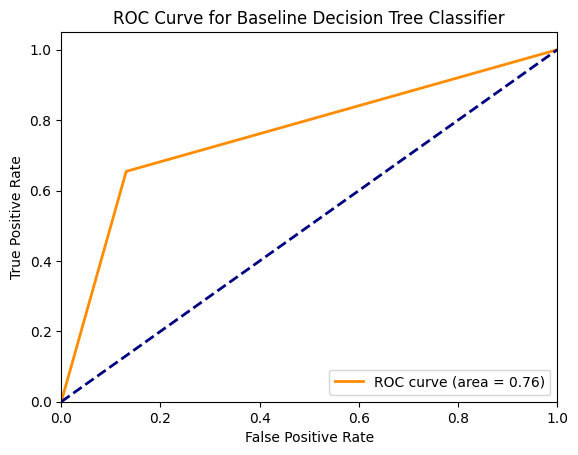

Training Accuracy: 0.9999122524788675
Testing Accuracy: 0.8188766805432335
Test F-score for Baseline classifier: 0.6277699859747546


,support,itemset,fp,fp_div,fp_t,length,support_count
0,0.102023,"(race=White, education=Bachelors, gender=Male)",0.099546,0.059847,9.743423,3,4983.0
1,0.113591,"(education=Bachelors, gender=Male)",0.098331,0.058632,10.214834,2,5548.0
2,0.126367,(occupation=Prof-specialty),0.075561,0.035862,7.749054,1,6172.0
3,0.110950,"(race=White, occupation=Prof-specialty)",0.075043,0.035344,7.125096,2,5419.0
4,0.144015,"(race=White, education=Bachelors)",0.073219,0.033521,7.966829,2,7034.0
5,0.112076,"(race=White, occupation=Exec-managerial)",0.072812,0.033113,6.638103,2,5474.0
6,0.164305,(education=Bachelors),0.072368,0.032670,8.393010,1,8025.0
7,0.124606,(occupation=Exec-managerial),0.072058,0.032359,6.932369,1,6086.0
8,0.588326,"(race=White, gender=Male)",0.054499,0.014801,7.759997,2,28735.0
9,0.668482,(gender=Male),0.052965,0.013266,7.384709,1,32650.0


In [16]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.metrics import accuracy_score
from divexplorer.outcomes import get_false_positive_rate_outcome
from divexplorer import DivergenceExplorer, DivergencePatternProcessor # Needed for Shapley values
import matplotlib.pyplot as plt
from sklearn import tree
import numpy as np
from sklearn.tree import _tree
from sklearn.tree._tree import TREE_LEAF
from sklearn.tree import _tree
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.tree import export_graphviz
import graphviz
import pydot
from IPython.display import Image
from sklearn.metrics import accuracy_score, f1_score
import os
import copy




def standardize_name(feature_name):
    """
    Extracts the base feature name from a one-hot encoded feature name.

    Args:
        feature_name: The one-hot encoded feature name (e.g., 'age_25-45').

    Returns:
        The base feature name (e.g., 'age').
    """

    # Find the index of the first underscore, if it exists
    underscore_index = feature_name.find("_")

    # If an underscore is found, return the substring before it
    if underscore_index != -1:
        return feature_name[:underscore_index]

    # If no underscore is found, return the original feature name
    return feature_name




# Load the dataset
income_df = pd.read_csv('adult.csv')

# Replace '?' with NaN for entire DataFrame
income_df = income_df.replace('?', pd.NA)

# Encode the 'income' column to binary format, interpretable for binary classification
income_df['income'] = income_df['income'].map({'<=50K': 0, '>50K': 1})

# One-hot encode the categorical columns
categorical_cols = ['age', 'workclass',  'education', 'marital-status', 'occupation', 'relationship', 'race', 'gender', 'native-country']
income_df_encoded = pd.get_dummies(income_df, columns=categorical_cols)


y = income_df['income']
X = income_df_encoded.drop(columns=['income'])

# Split the dataset into training (70%) and testing (30%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Add the continuous columns back into X_train and X_test
continuous_cols = ['fnlwgt', 'educational-num', 'capital-gain', 'capital-loss', 'hours-per-week']
X_train[continuous_cols] = income_df[continuous_cols].iloc[X_train.index]
X_test[continuous_cols] = income_df[continuous_cols].iloc[X_test.index]

expanded_feature_names = X_train.columns.tolist()

income_df_baseline = income_df.copy() # Use a copy of the dataframe for analysis

# Initialize the Decision Tree classifier
dt_classifier = DecisionTreeClassifier(random_state=42, class_weight='balanced')

# Fit the classifier to the data
dt_classifier.fit(X_train, y_train)

income_df_baseline['predicted_dt'] = dt_classifier.predict(X)

tn = (income_df['income'] == 0) & (income_df_baseline['predicted_dt'] == 0)  # True Negatives
fp = (income_df['income'] == 0) & (income_df_baseline['predicted_dt'] == 1)  # False Positives
overall_fp_rate = fp.sum() / (fp.sum() + tn.sum())
print("Overall False Positive Rate of the baseline Decision Tree Classifier:", overall_fp_rate)

itemset_mask_before = (income_df_baseline['education'] == 'Bachelors') & \
                      (income_df_baseline['race'] == 'White') & \
                      (income_df_baseline['gender'] == 'Male')

itemset_data_before = income_df_baseline[itemset_mask_before]

fp_before = (itemset_data_before['income'] == 0) & (itemset_data_before['predicted_dt'] == 1)
tn_before = (itemset_data_before['income'] == 0) & (itemset_data_before['predicted_dt'] == 0)
conditional_fp_rate_before = fp_before.sum() / (fp_before.sum() + tn_before.sum())

print("Baseline Classifier's Conditional FP Rate on most divergent itemset:", conditional_fp_rate_before)


y_pred_proba = dt_classifier.predict_proba(X_test)[:, 1]

# Calculate ROC curve values
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

print("ROC AUC:", roc_auc)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Baseline
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Baseline Decision Tree Classifier')
plt.legend(loc="lower right")
plt.show()


income_df_baseline['fp'] = get_false_positive_rate_outcome(y, income_df_baseline['predicted_dt'])

train_accuracy = accuracy_score(y_train, dt_classifier.predict(X_train))
test_accuracy = accuracy_score(y_test, dt_classifier.predict(X_test))
print(f"Training Accuracy: {train_accuracy}")
print(f"Testing Accuracy: {test_accuracy}")

y_pred_pruned = dt_classifier.predict(X_test)
f_score = f1_score(y_test, y_pred_pruned)

print(f"Test F-score for Baseline classifier: {f_score}")


# Perform divergence analysis with DivExplorer for the original(unpruned) DecisionTreeClassifier
fp_diver = DivergenceExplorer(income_df_baseline)
attributes = ['education', 'occupation', 'race', 'gender']
FP_fm = fp_diver.get_pattern_divergence(min_support=0.1, attributes=attributes, boolean_outcomes=['fp'])
FP_fm = FP_fm.sort_values(by="fp_div", ascending=False, ignore_index=True)
FP_fm.head(10)











# The four post-pruning approaches in the report are implemented in the following cells: Rule-Based Pruning, Feature Importance Pruning, Divergence-based Subtree Pruning, and Depth Constrained Shapley-Importance Pruning

##Approach 1: Rule-based pruning

In prune_tree(), most divergent itemset features are:  {'race', 'education', 'gender'}
Decision path after pruning:
In debug_decision_path(), The length of X is:  1
Sample 0:
Node 0: (Feature marital-status_Married-civ-spouse <= 0.5)
Node 1: (Feature capital-gain <= 4668.5)
Node 2: (Feature educational-num <= 12.5)
Node 3: (Feature capital-loss <= 2218.5)
Node 4: (Feature hours-per-week <= 44.5)
Node 5: (Feature marital-status_Married-AF-spouse <= 0.5)
Node 6: (Feature occupation_Prof-specialty <= 0.5)
Node 7: (Feature relationship_Not-in-family <= 0.5)
Node 8: (Feature age_75 <= 0.5)
Node 9: (Feature relationship_Unmarried <= 0.5)
Node 10: (Feature native-country_Guatemala <= 0.5)
Node 11: (Feature age_52 <= 0.5)
Node 12: (Feature age_32 <= 0.5)
Node 13: (Feature occupation_Protective-serv <= 0.5)
Node 14: (Feature age_30 <= 0.5)
Node 15: (Feature age_22 <= 0.5)
Node 16: (Feature education_12th <= 0.5)
Node 17: (Feature age_44 <= 0.5)
Leaf node
Nodes to prune are:  [284, 288, 311, 320

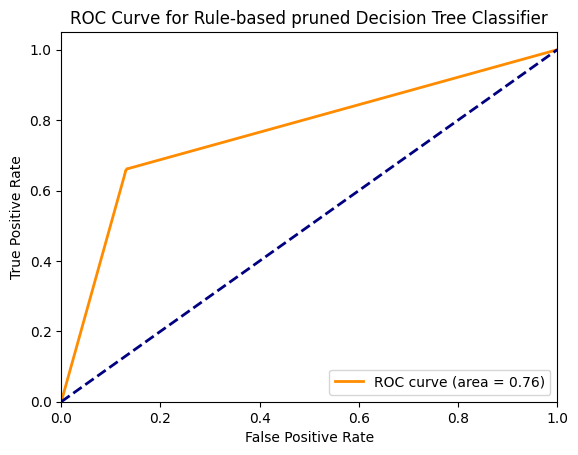

Most divergent itemsets after pruning     support                                            itemset  fp_pruned  \
0  0.112076           (race=White, occupation=Exec-managerial)   0.105093   
1  0.124606                       (occupation=Exec-managerial)   0.101951   
2  0.102023     (race=White, education=Bachelors, gender=Male)   0.099959   
3  0.113591                 (education=Bachelors, gender=Male)   0.098694   
4  0.126367                        (occupation=Prof-specialty)   0.078217   
5  0.110950            (race=White, occupation=Prof-specialty)   0.078141   
6  0.144015                  (race=White, education=Bachelors)   0.074708   
7  0.164305                              (education=Bachelors)   0.073854   
8  0.120572  (race=White, education=Some-college, gender=Male)   0.072744   
9  0.137177              (education=Some-college, gender=Male)   0.068966   

   fp_pruned_div  fp_pruned_t  length  support_count  
0       0.061115    10.387546       2         5474.0  
1   

In [17]:

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.metrics import accuracy_score
from divexplorer.outcomes import get_false_positive_rate_outcome
from divexplorer import DivergenceExplorer
import matplotlib.pyplot as plt
from sklearn import tree
import numpy as np
from sklearn.tree import _tree
from sklearn.tree._tree import TREE_LEAF
from sklearn.tree import _tree
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.tree import export_graphviz
import graphviz
import pydot
from IPython.display import Image
import os



"""
Extracts features from a given itemset(as opposed to the specific values these features assume)
Args:
FP_fm: The dataframe produced by DivExplorer, sorted in descending order of divergence metric

Returns: Set: The features present in the maximally divergent itemset

"""

def extract_features_from_itemset(FP_fm):
  return set([condition.split('=')[0] for condition in FP_fm.iloc[0]['itemset']])



def calculate_tree_depth(tree, node, depth = 0):
    """
    Calculates the depth of a decision tree recursively.

    Args:
        tree: The DecisionTreeClassifier object representing the tree.
        node: The index of the node to start calculating depth from.
        depth: The current depth (initially 0 for the root node).

    Returns:
        The depth of the subtree rooted at the given node.
    """

    if node == -1: # Leaf node
        return depth
    left_depth = calculate_tree_depth(tree, tree.tree_.children_left[node], depth + 1)
    right_depth = calculate_tree_depth(tree, tree.tree_.children_right[node], depth + 1)
    return max(left_depth, right_depth)




"""
This function prints the decision path in the DecisionTreeClassifier corresponding to a particular itemset. It is invoked on a particular itemset, both before and after pruning to validate that pruning has occurred.
Args:
clf: The trained DecisionTreeClassifier
X: The One-Hot-Encoded representation of the particular(singular) divergent itemset under consideration
feature_names: The expanded, One-Hot-Encoded features columns names in X
"""

def debug_decision_path(clf, X, feature_names):
    decision_path = clf.decision_path(X).toarray()
    print("In debug_decision_path(), The length of X is: ", len(X))
    for sample_index in range(X.shape[0]):
        print(f"Sample {sample_index}:")
        node_indices = decision_path[sample_index].nonzero()[0]
        for node_id in node_indices:
            if clf.tree_.feature[node_id] != _tree.TREE_UNDEFINED:
                feature_index = clf.tree_.feature[node_id]
                if feature_index < len(feature_names):
                    feature_name = feature_names[feature_index]
                    threshold = clf.tree_.threshold[node_id]
                    threshold_sign = "<=" if X.iloc[sample_index][feature_name] <= threshold else ">"
                    print(f"Node {node_id}: (Feature {feature_name} {threshold_sign} {threshold})")
                else:
                    print(f"Node {node_id}: (Leaf node)")
            else:
                print("Leaf node")



def check_feature(feature_name, divergent_itemset_features):
    """
    Checks if a feature name (one-hot encoded) is present in the list of divergent itemset features(not in one-hot encoded form).

    Args:
        feature_name: The name of the feature to check (e.g., 'age_25-45').
        divergent_itemset_features: A list of features in the divergent itemset (e.g., ['#prior', 'race', 'age', 'charge']).

    Returns:
        True if the feature name starts with any of the divergent feature substrings, False otherwise.
    """

    # Convert feature name to lowercase for case-insensitive comparison
    feature_name_lower = feature_name.lower()

    # Check if the feature name starts with any of the divergent feature substrings
    for divergent_feature in divergent_itemset_features:
        if feature_name_lower.startswith(divergent_feature.lower()):
            return True

    return False





"""
This function performs rules-based pruning on the DecisionTreeClassifier based on the most divergent itemset found by DivExplorer.
Args:
clf: The DecisionTreeClassifier
feature_names: The features present in the dataset
divergent_itemset_features: The features in the maximally divergent itemset
expanded_feature_names: One-hot-encoded column names
encoded_df: The entirety of the encoded dataframe
X_train: The training dataset

"""


def prune_tree_based_on_itemset(clf, feature_names, divergent_itemset_features, expanded_feature_names, encoded_df, X_train):
    n_nodes = clf.tree_.node_count
    children_left = clf.tree_.children_left
    children_right = clf.tree_.children_right

    assert clf.tree_.node_count > 0, "Decision tree classifier has no nodes"

    feature_decision_split = clf.tree_.feature

    # Most divergent itemset
    divergent_itemset_values = {
        'gender': 'Male',
        'race': 'White',
        'education': 'Bachelors'
    }

    # Convert the dictionary to a DataFrame
    X_debug = pd.DataFrame([divergent_itemset_values])

    # Apply pd.get_dummies() to convert categorical variables to dummy/indicator variables
    X_debug_encoded = pd.get_dummies(X_debug)

    # Reorder the columns to match the order in income_df_encoded, filling missing columns with 0
    X_debug_encoded = X_debug_encoded.reindex(columns=encoded_df.columns, fill_value=0)

    # Ensure X_debug_encoded has the same structure as the training data
    X_debug_encoded = X_debug_encoded.reindex(columns=X_train.columns, fill_value=0)

    assert not X_debug_encoded.isnull().values.any(), "DataFrame contains null values after processing"
    assert X_debug_encoded.shape[1] == X_train.shape[1], "X_debug_encoded has incorrect number of features"

    # This list will hold the indices of the nodes to prune
    nodes_to_prune = []

    feature_names = expanded_feature_names

    def recurse(node, features_in_path):
      # If it's a leaf node, no further action is necessary
      if children_left[node] == children_right[node] == -1:
          return

      # Determine the feature name of the current node
      if feature_decision_split[node] != _tree.TREE_UNDEFINED:
          feature_name = feature_names[feature_decision_split[node]]
          assert feature_name in expanded_feature_names, "Feature used for splitting not found in feature names"

      else:
          feature_name = "leaf"


      # If the current node is a split node, process further
      if feature_name != "leaf":

        current_feature = standardize_name(feature_name)
        features_in_path_copy = features_in_path.copy()  # Create a copy
        features_in_path_copy.append(current_feature)  # Add to the copy

        if divergent_itemset_features.issubset(set(features_in_path_copy)):  # Check on the copy
            nodes_to_prune.append(node)
            return
          # Add the feature of the current node to the path
        features_in_path = features_in_path + [standardize_name(feature_name)]

      # Continue recursion on the children nodes
      if children_left[node] != -1:
          recurse(children_left[node], features_in_path)
      if children_right[node] != -1:
          recurse(children_right[node], features_in_path)

      #Invoke the recurse function starting from the root node
    recurse(0, [])

    # Prune the marked nodes
    for node_to_prune in nodes_to_prune:
      clf.tree_.children_left[node_to_prune] = _tree.TREE_LEAF
      clf.tree_.children_right[node_to_prune] = _tree.TREE_LEAF
      clf.tree_.feature[node_to_prune] = _tree.TREE_UNDEFINED
      clf.tree_.threshold[node_to_prune] = -2

    print("Decision path after pruning:")
    debug_decision_path(clf, X_debug_encoded, expanded_feature_names)

    assert len(nodes_to_prune) > 0

    return clf, nodes_to_prune  # Return the modified classifier and nodes marked for pruning


def prune_tree(clf, FP_fm, expanded_feature_names, encoded_df, X_train):
    all_features = [
    'age',
    'workclass',
    'fnlwgt',
    'education',
    'educational-num',
    'marital-status',
    'occupation',
    'relationship',
    'race',
    'gender',
    'capital-gain',
    'capital-loss',
    'hours-per-week',
    'native-country',
    'income']

    # Get the most divergent itemset
    most_divergent_itemset_features = extract_features_from_itemset(FP_fm)

    print("In prune_tree(), most divergent itemset features are: ", most_divergent_itemset_features)

    # Proceed with pruning based on this itemset
    pruned_clf, nodes_to_prune = prune_tree_based_on_itemset(clf, all_features, most_divergent_itemset_features, expanded_feature_names, encoded_df, X_train)

    assert clf.tree_.node_count >= pruned_clf.tree_.node_count, "Node count did not decrease after pruning"

    return pruned_clf, nodes_to_prune



def visualize_pruned_tree(dt_classifier, feature_names, class_names, pruned_nodes, output_filename='pruned_tree'):
    """Exports a GraphViz representation of a decision tree and highlights pruned nodes using pydot."""
    # Export the decision tree to a dot file
    export_graphviz(dt_classifier, out_file="tree.dot",
                    feature_names=feature_names,
                    class_names=class_names,
                    filled=True, rounded=True)

    graphs = pydot.graph_from_dot_file('tree.dot')
    if graphs is None:
        raise ValueError("Could not load dot file.")
    graph = graphs[0]

    # Iterate through nodes in the graph and highlight pruned nodes
    for node in graph.get_nodes():
        node_id = node.get_name().strip('"')
        if node_id.isdigit() and int(node_id) in pruned_nodes:
            node.set_fillcolor('#ff9999')  # Light red
            node.set_style('filled')
            node.set_shape('diamond')  # Change shape to diamond
            node.set_label("Pruned\n" + node.get_label())  # Add 'Pruned' text to label

    output_path_dot = os.path.join(os.getcwd(), f"{output_filename}.dot")
    graph.write_dot(output_path_dot)

    output_path_png = os.path.join(os.getcwd(), f"{output_filename}.png")
    graph.write_png(output_path_png)

    return Image(output_path_png)


income_df_rules = income_df.copy() # Make a copy for this approach

# Drop the old 'fp' and 'predicted_dt' columns to avoid confusion
#income_df.drop(columns=['fp', 'predicted_dt'], inplace=True, errors='ignore')

pruned_dt_classifier, nodes_to_prune = prune_tree(dt_classifier, FP_fm, expanded_feature_names, income_df_encoded, X_train) # Prune the decision tree based on DivExplorer analysis of the most divergent itemsets of the original tree

print("Nodes to prune are: ", nodes_to_prune)

# Make predictions with the newly pruned classifier
income_df_rules['predicted_dt_pruned'] = pruned_dt_classifier.predict(X)

# Calculate and Print the Overall False Positive Rate after pruning
tn_pruned = (income_df_rules['income'] == 0) & (income_df_rules['predicted_dt_pruned'] == 0)  # True Negatives
fp_pruned = (income_df_rules['income'] == 0) & (income_df_rules['predicted_dt_pruned'] == 1)  # False Positives

overall_fp_rate_pruned = fp_pruned.sum() / (fp_pruned.sum() + tn_pruned.sum())

print("Overall False Positive Rate of Decision Tree After Pruning:", overall_fp_rate_pruned)

# After Pruning: Re-run conditional FP rate on pruned model's `predicted_dt_pruned`

itemset_mask_after = (income_df_rules['education'] == 'Bachelors') & \
                      (income_df_rules['race'] == 'White') & \
                      (income_df_rules['gender'] == 'Male')

itemset_data_after = income_df_rules[itemset_mask_after]
fp_after = (itemset_data_after['income'] == 0) & (itemset_data_after['predicted_dt_pruned'] == 1)
tn_after = (itemset_data_after['income'] == 0) & (itemset_data_after['predicted_dt_pruned'] == 0)

conditional_fp_rate_after = fp_after.sum() / (fp_after.sum() + tn_after.sum())

print("Conditional FP Rate on most divergent itemset (AFTER Pruning):", conditional_fp_rate_after)

# Compute the false positive rate for the pruned predictions
income_df_rules['fp_pruned'] = get_false_positive_rate_outcome(y, income_df_rules['predicted_dt_pruned'])

# Perform divergence analysis again with the pruned predictions
fp_diver_pruned = DivergenceExplorer(income_df_rules)
attributes = ['education', 'occupation', 'race', 'gender']
FP_fm_pruned = fp_diver_pruned.get_pattern_divergence(min_support=0.1, attributes=attributes, boolean_outcomes=['fp_pruned'])

test_accuracy = accuracy_score(y_test, pruned_dt_classifier.predict(X_test))
print(f"Testing Accuracy for pruned classifier: {test_accuracy}")

y_pred_pruned = pruned_dt_classifier.predict(X_test)
f_score = f1_score(y_test, y_pred_pruned)

print(f"Test F-score for Rule-Based-Pruning: {f_score}")

y_pred_proba = pruned_dt_classifier.predict_proba(X_test)[:, 1]

# Calculate ROC curve values
fpr_pruned, tpr_pruned, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr_pruned, tpr_pruned)

print("ROC AUC:", roc_auc)

plt.figure()
plt.plot(fpr_pruned, tpr_pruned, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Baseline
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Rule-based pruned Decision Tree Classifier')
plt.legend(loc="lower right")
plt.show()


FP_fm_pruned = FP_fm_pruned.sort_values(by="fp_pruned_div", ascending=False, ignore_index=True)


print("Most divergent itemsets after pruning", FP_fm_pruned.head(10))



##Approach 2: Feature Importance Pruning

Number of subtrees pruned: 52
Overall False Positive Rate of Decision Tree After Feature Importance Pruning: 0.04938770017494281
Conditional FP Rate on most divergent itemset (AFTER Feature Importance Pruning): 0.12432878975629905
Testing Accuracy for Feature Importance Pruned classifier: 0.8298641916331126
ROC AUC: 0.7923575612374358
Test F-score for Feature Importance Pruning: 0.6253944402704733


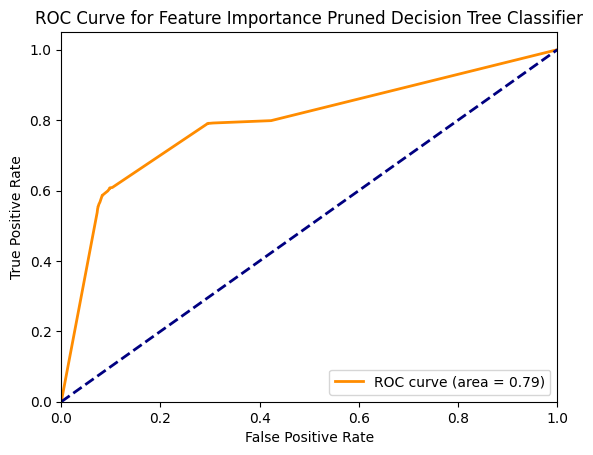

Most divergent itemsets after feature importance pruning


,support,itemset,fp_dafip,fp_dafip_div,fp_dafip_t,length,support_count
0,0.120572,"(race=White, education=Some-college, gender=Male)",0.145022,0.095634,17.433870,3,5889.0
1,0.137177,"(education=Some-college, gender=Male)",0.138134,0.088746,17.626436,2,6700.0
2,0.113591,"(education=Bachelors, gender=Male)",0.126633,0.077245,12.040174,2,5548.0
3,0.102023,"(race=White, education=Bachelors, gender=Male)",0.124329,0.074941,11.058720,3,4983.0
4,0.110950,"(race=White, occupation=Prof-specialty)",0.114286,0.064898,10.834961,2,5419.0
5,0.126367,(occupation=Prof-specialty),0.114227,0.064839,11.653161,1,6172.0
6,0.164305,(education=Bachelors),0.105688,0.056300,12.218855,1,8025.0
7,0.144015,"(race=White, education=Bachelors)",0.103748,0.054360,11.047870,2,7034.0
8,0.190185,"(race=White, education=Some-college)",0.091618,0.042231,11.984105,2,9289.0
9,0.222718,(education=Some-college),0.085082,0.035695,11.253183,1,10878.0


In [18]:

def dafip(clf, divergent_itemset, income_df, X, y_true, feature_importance_threshold=0.03):


    feature_names = clf.feature_names_in_

    # feature importance scores
    feature_importances = clf.feature_importances_

    # dictionary to store feature importance scores
    feature_importance_dict = dict(zip(feature_names, feature_importances))

    nodes_to_prune = []

    pruning_decision_count = 0


    def traverse(node_id):
        # Get the feature and threshold of the current node
        nonlocal pruning_decision_count
        feature = clf.tree_.feature[node_id]

        # Check if the current node is a leaf node
        if feature == _tree.TREE_UNDEFINED:
            return

        # Get the feature name of the current node
        feature_name = feature_names[feature]

        standardized_feature_name = standardize_name(feature_name) # Standardize feature name


        # Check if the feature is present in the divergent itemset
        if standardized_feature_name in [item.split('=')[0] for item in divergent_itemset]:
            # Get the feature importance score of the current feature
            feature_importance = feature_importance_dict[feature_name]

            # Check if the feature importance score is above the threshold
            if feature_importance > feature_importance_threshold:
                nodes_to_prune.append(node_id)
                pruning_decision_count+=1
                return

        # Recursively traverse the left and right subtrees
        traverse(clf.tree_.children_left[node_id])
        traverse(clf.tree_.children_right[node_id])

    # Start the recursive traversal from the root node
    traverse(0)

    # Prune the marked nodes
    for node_id in nodes_to_prune:
        clf.tree_.children_left[node_id] = _tree.TREE_LEAF
        clf.tree_.children_right[node_id] = _tree.TREE_LEAF
        clf.tree_.feature[node_id] =  _tree.TREE_UNDEFINED
        clf.tree_.threshold[node_id] = _tree.TREE_UNDEFINED

    print(f"Number of subtrees pruned: {pruning_decision_count}")
    return clf

# Make a copy of income_df for this approach
income_df_fip = income_df.copy()

# Initialize the Decision Tree classifier
dt_classifier = DecisionTreeClassifier(random_state=42, class_weight='balanced')

# Fit the classifier to the data
dt_classifier.fit(X_train, y_train)

divergent_itemset = ('race=White', 'education=Bachelors', 'gender=Male')
feature_importance_threshold = 0.005
dafip_classifier = dafip(dt_classifier, divergent_itemset, income_df_fip, X, y, feature_importance_threshold)


income_df_fip['predicted_dt_dafip'] = dafip_classifier.predict(X)


tn_dafip = (income_df_fip['income'] == 0) & (income_df_fip['predicted_dt_dafip'] == 0)
fp_dafip = (income_df_fip['income'] == 0) & (income_df_fip['predicted_dt_dafip'] == 1)
overall_fp_rate_dafip = fp_dafip.sum() / (fp_dafip.sum() + tn_dafip.sum())
print("Overall False Positive Rate of Decision Tree After Feature Importance Pruning:", overall_fp_rate_dafip)


itemset_mask_after = (income_df_fip['education'] == 'Bachelors') & (income_df_fip['race'] == 'White') & (income_df_fip['gender'] == 'Male')
itemset_data_after = income_df_fip[itemset_mask_after]
fp_after = (itemset_data_after['income'] == 0) & (itemset_data_after['predicted_dt_dafip'] == 1)
tn_after = (itemset_data_after['income'] == 0) & (itemset_data_after['predicted_dt_dafip'] == 0)
conditional_fp_rate_after = fp_after.sum() / (fp_after.sum() + tn_after.sum())
print("Conditional FP Rate on most divergent itemset (AFTER Feature Importance Pruning):", conditional_fp_rate_after)


income_df_fip['fp_dafip'] = get_false_positive_rate_outcome(y, income_df_fip['predicted_dt_dafip'])


fp_diver_dafip = DivergenceExplorer(income_df_fip)
attributes = ['education', 'occupation', 'race', 'gender']
FP_fm_dafip = fp_diver_dafip.get_pattern_divergence(min_support=0.1, attributes=attributes, boolean_outcomes=['fp_dafip'])

test_accuracy = accuracy_score(y_test, dafip_classifier.predict(X_test))
print(f"Testing Accuracy for Feature Importance Pruned classifier: {test_accuracy}")

y_pred_proba = dafip_classifier.predict_proba(X_test)[:, 1]

# Calculate ROC curve values
fpr_pruned, tpr_pruned, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr_pruned, tpr_pruned)

print("ROC AUC:", roc_auc)

y_pred_pruned = dafip_classifier.predict(X_test)
f_score = f1_score(y_test, y_pred_pruned)

print(f"Test F-score for Feature Importance Pruning: {f_score}")

plt.figure()
plt.plot(fpr_pruned, tpr_pruned, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Feature Importance Pruned Decision Tree Classifier')
plt.legend(loc="lower right")
plt.show()

FP_fm_dafip = FP_fm_dafip.sort_values(by="fp_dafip_div", ascending=False, ignore_index=True)
print("Most divergent itemsets after feature importance pruning")
FP_fm_dafip.head(10)



##Approach 3: Divergence-based Subtree Pruning

In [19]:



Calculate the divergence of a hypothetically pruned DecisionTreeClassifier(one without the subtree) vs one with the subtree
param: clf, the DecisionTreeClassifier
param: income_df, the income dataframe
param: include_subtree, whether or not to consider the subtree rooted at the current node. calculate_divergence() should be called twice, once with the subtree included and once with the subtree NOT included


def calculate_divergence(clf, X, y_true, divergent_itemset, node_id, income_df, include_subtree=True):

    income_df_copy = copy.deepcopy(income_df)
    clf_copy = copy.deepcopy(clf)

    if not include_subtree:
        # Prune the subtree rooted at the current node and replace it with a leaf node
        clf_copy.tree_.children_left[node_id] = _tree.TREE_LEAF
        clf_copy.tree_.children_right[node_id] = _tree.TREE_LEAF
        clf_copy.tree_.feature[node_id] = _tree.TREE_UNDEFINED
        clf_copy.tree_.threshold[node_id] = _tree.TREE_UNDEFINED



    # Generate predictions using the modified classifier
    income_df_copy['curr_preds'] = clf_copy.predict(X)

    # Calculate the false positive rate for the divergent itemset
    income_df_copy['fp_test_outcome'] = get_false_positive_rate_outcome(y_true, income_df_copy['curr_preds'])

    fp_diver_test = DivergenceExplorer(income_df_copy)

    attributes = ['education', 'occupation', 'race', 'gender']

    FP_fm_test = fp_diver_test.get_pattern_divergence(min_support=0.1, attributes=attributes, boolean_outcomes=['fp_test_outcome'])

    # Mask that matches the itemset
    mask = FP_fm_test['itemset'].apply(lambda x: all(item in x for item in divergent_itemset))

    # Use the mask to locate the row
    matched_row = FP_fm_test[mask]

   # Obtain the divergence value from the row
    fp_curr_div = matched_row['fp_test_outcome_div'].iloc[0] if not matched_row.empty else None

    return fp_curr_div



def dbsp(clf, divergent_itemset, income_df, X, y_true, threshold=0.00000001): # Threshold is 0.003: the maximally divergent itemset has a divergence of around 0.05.
    feature_names = clf.feature_names_in_

    nodes_to_prune = []

    pruning_decision_count = 0

    # Recursive function for traversing the tree
    def traverse(node_id, is_root=False):
        nonlocal pruning_decision_count

        # Get the feature and threshold of the current node
        feature = clf.tree_.feature[node_id]
        threshold = clf.tree_.threshold[node_id]

        # Check if the current node is a leaf node
        if feature == _tree.TREE_UNDEFINED:
            return

        # Get the feature name of the current node
        feature_name = feature_names[feature]

        standardized_feature_name = standardize_name(feature_name)

        # Check if the feature is present in the divergent itemset and the node is not the root(don't prune the root, which would destroy the entire DecisionTreeClassifier)
        if standardized_feature_name in [item.split('=')[0] for item in divergent_itemset] and not is_root:
            # Calculate the divergence with the subtree included
            fp_div_with_subtree = calculate_divergence(clf, X, y_true, divergent_itemset, node_id, income_df, include_subtree=True)

            # Calculate the divergence with the subtree pruned
            fp_div_without_subtree = calculate_divergence(clf, X, y_true, divergent_itemset, node_id, income_df, include_subtree=False)

            # Check if pruning the subtree leads to a significant reduction in divergence
            if fp_div_without_subtree is not None and fp_div_with_subtree is not None:
                if fp_div_without_subtree < fp_div_with_subtree - threshold:
                    pruning_decision_count += 1
                    nodes_to_prune.append(node_id)
                    return

        # Recursively traverse the left and right subtrees
        traverse(clf.tree_.children_left[node_id])
        traverse(clf.tree_.children_right[node_id])

    # Start the recursive traversal from the root node
    traverse(0, is_root=True)

    # Prune the marked nodes
    for node_id in nodes_to_prune:
        clf.tree_.children_left[node_id] = _tree.TREE_LEAF
        clf.tree_.children_right[node_id] = _tree.TREE_LEAF
        clf.tree_.feature[node_id] = _tree.TREE_UNDEFINED
        clf.tree_.threshold[node_id] = _tree.TREE_UNDEFINED

    print(f"Number of subtrees pruned: {pruning_decision_count}")
    return clf


# Initialize the base Decision Tree classifier
dt_classifier = DecisionTreeClassifier(random_state=42, class_weight='balanced')

# Fit the base classifier to the data
dt_classifier.fit(X_train, y_train)



dbsp_classifier = dbsp(dt_classifier,('race=White', 'education=Bachelors', 'gender=Male'), income_df, X, y)


# Make a copy of income_df for this approach
income_df_dbsp = income_df.copy()


# Make predictions
income_df_dbsp['predicted_dt_dbsp'] = dbsp_classifier.predict(X)



# Calculate and Print the Overall False Positive Rate after dbsp
tn_dbsp = (income_df_dbsp['income'] == 0) & (income_df_dbsp['predicted_dt_dbsp'] == 0)  # True Negatives
fp_dbsp = (income_df_dbsp['income'] == 0) & (income_df_dbsp['predicted_dt_dbsp'] == 1)  # False Positives

overall_fp_rate_dbsp = fp_dbsp.sum() / (fp_dbsp.sum() + tn_dbsp.sum())

print("Overall False Positive Rate of Decision Tree After Subtree Pruning:", overall_fp_rate_dbsp)


itemset_mask_after = (income_df_dbsp['education'] == 'Bachelors') & \
                      (income_df_dbsp['race'] == 'White') & \
                      (income_df_dbsp['gender'] == 'Male')

itemset_data_after = income_df_dbsp[itemset_mask_after]
fp_after = (itemset_data_after['income'] == 0) & (itemset_data_after['predicted_dt_dbsp'] == 1)
tn_after = (itemset_data_after['income'] == 0) & (itemset_data_after['predicted_dt_dbsp'] == 0)

conditional_fp_rate_after = fp_after.sum() / (fp_after.sum() + tn_after.sum())

print("Conditional FP Rate on most divergent itemset (AFTER Subtree Pruning):", conditional_fp_rate_after)


income_df_dbsp['fp_dbsp'] = get_false_positive_rate_outcome(y, income_df_dbsp['predicted_dt_dbsp'])


fp_diver_dbsp = DivergenceExplorer(income_df_dbsp)
attributes = ['education', 'occupation', 'race', 'gender']
FP_fm_dbsp = fp_diver_dbsp.get_pattern_divergence(min_support=0.1, attributes=attributes, boolean_outcomes=['fp_dbsp'])


test_accuracy = accuracy_score(y_test, dbsp_classifier.predict(X_test))
print(f"Testing Accuracy for Subtree Pruned classifier: {test_accuracy}")


y_pred_proba = dbsp_classifier.predict_proba(X_test)[:, 1]


fpr_pruned, tpr_pruned, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr_pruned, tpr_pruned)

print("ROC AUC:", roc_auc)

plt.figure()
plt.plot(fpr_pruned, tpr_pruned, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Subtree Pruned Decision Tree Classifier')
plt.legend(loc="lower right")
plt.show()


FP_fm_dbsp = FP_fm_dbsp.sort_values(by="fp_dbsp", ascending=False, ignore_index=True)


print("Most divergent itemsets after pruning") # Get the most divergent itemsets after pruning

FP_fm_dbsp.head(10)







'\nCalculate the divergence of a hypothetically pruned DecisionTreeClassifier(one without the subtree) vs one with the subtree\nparam: clf, the DecisionTreeClassifier\nparam: income_df, the income dataframe\nparam: include_subtree, whether or not to consider the subtree rooted at the current node. calculate_divergence() should be called twice, once with the subtree included and once with the subtree NOT included\n\n\ndef calculate_divergence(clf, X, y_true, divergent_itemset, node_id, income_df, include_subtree=True):\n\n    income_df_copy = copy.deepcopy(income_df)\n    clf_copy = copy.deepcopy(clf)\n\n    if not include_subtree:\n        # Prune the subtree rooted at the current node and replace it with a leaf node\n        clf_copy.tree_.children_left[node_id] = _tree.TREE_LEAF\n        clf_copy.tree_.children_right[node_id] = _tree.TREE_LEAF\n        clf_copy.tree_.feature[node_id] = _tree.TREE_UNDEFINED\n        clf_copy.tree_.threshold[node_id] = _tree.TREE_UNDEFINED\n\n\n\n    #

##Approach 4: Depth-Constrained Shapley-Importance Pruning

Training Accuracy: 0.9999122524788675
Testing Accuracy: 0.8188766805432335
Number of nodes pruned: 3
SIP Threshold: 5e-08
Most divergent itemsets after SIP Pruning:
    support                                            itemset  fp_svp_5e-08  \
0  0.102023     (race=White, education=Bachelors, gender=Male)      0.099546   
1  0.113591                 (education=Bachelors, gender=Male)      0.098331   
2  0.110950            (race=White, occupation=Prof-specialty)      0.078830   
3  0.126367                        (occupation=Prof-specialty)      0.078808   
4  0.144015                  (race=White, education=Bachelors)      0.073219   
5  0.112076           (race=White, occupation=Exec-managerial)      0.072812   
6  0.164305                              (education=Bachelors)      0.072368   
7  0.124606                       (occupation=Exec-managerial)      0.072058   
8  0.118525             (occupation=Craft-repair, gender=Male)      0.062401   
9  0.107653  (race=White, occupatio

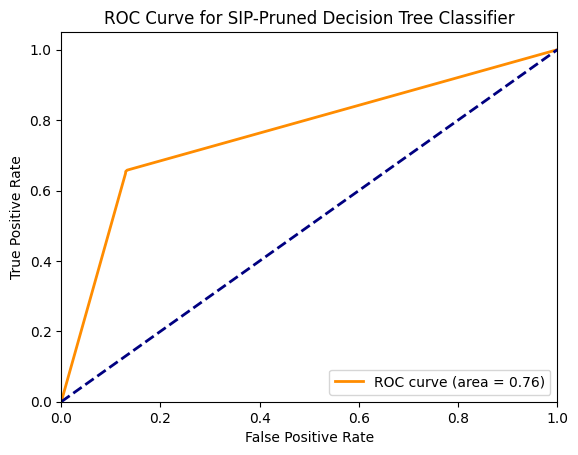

---


In [20]:

def calculate_tree_depth(tree, node, depth = 0):
    """
    Calculates the depth of a decision tree recursively.

    Args:
        tree: The DecisionTreeClassifier object representing the tree.
        node: The index of the node to start calculating depth from.
        depth: The current depth (initially 0 for the root node).

    Returns:
        The depth of the subtree rooted at the given node.
    """

    if node == -1: # Leaf node
        return depth
    left_depth = calculate_tree_depth(tree, tree.tree_.children_left[node], depth + 1)
    right_depth = calculate_tree_depth(tree, tree.tree_.children_right[node], depth + 1)
    return max(left_depth, right_depth)




def sip(clf, divergent_itemset, shapley_values, sip_threshold, depth_baseline, depth_threshold=0.70):
    feature_names = clf.feature_names_in_

    nodes_to_prune = []
    nodes_pruned = 0


    # Define the recursive function for traversing the tree
    def traverse(node_id, parent_impurity, current_depth):
        nonlocal nodes_pruned

        # Get the feature and threshold of the current node
        feature = clf.tree_.feature[node_id]
        threshold = clf.tree_.threshold[node_id]

        # Check if the current node is a leaf node
        if feature == _tree.TREE_UNDEFINED:
            return

        # Get the feature name of the current node
        feature_name = feature_names[feature]

        '''
        Impurity reduction calculation between a parent node and its two children, based on the code in Sklearn

        '''

        current_impurity = clf.tree_.impurity[node_id]
        left_child_id = clf.tree_.children_left[node_id]
        right_child_id = clf.tree_.children_right[node_id]

        if left_child_id != _tree.TREE_LEAF and right_child_id != _tree.TREE_LEAF:
            left_impurity = clf.tree_.impurity[left_child_id]
            right_impurity = clf.tree_.impurity[right_child_id]
            weighted_n_node_samples = clf.tree_.weighted_n_node_samples[node_id]
            weighted_n_left = clf.tree_.weighted_n_node_samples[left_child_id]
            weighted_n_right = clf.tree_.weighted_n_node_samples[right_child_id]

            impurity_reduction = (weighted_n_node_samples / clf.tree_.weighted_n_node_samples[0]) * (
                current_impurity - (weighted_n_right / weighted_n_node_samples * right_impurity)
                                 - (weighted_n_left / weighted_n_node_samples * left_impurity)
            )

        else:
            impurity_reduction = 0.0

        impurity_reduction = abs(impurity_reduction)


        # Standardize the feature name
        standardized_feature_name = standardize_name(feature_name)

        # Check if the standardized feature name is present in the divergent itemset
        for item in divergent_itemset:
            if standardized_feature_name == item.split('=')[0]:
                # Get the Shapley value of the feature
                shapley_value = shapley_values[frozenset({item})]

                shapley_value = abs(shapley_value)
                sip_value = shapley_value * impurity_reduction
                if  current_depth/depth_baseline >= depth_threshold and sip_value > sip_threshold: # Do not prune highly important nodes closer to the root
                    nodes_to_prune.append(node_id)
                    nodes_pruned += 1
                    return

        # Recursively traverse the left and right subtrees
        traverse(clf.tree_.children_left[node_id], current_impurity, current_depth + 1)
        traverse(clf.tree_.children_right[node_id], current_impurity, current_depth + 1)

    # Start the recursive traversal from the root node
    parent_impurity = clf.tree_.impurity[0]  # Root node impurity
    traverse(0, parent_impurity, 0) # Invoke traverse() with the root node's gini impurity, and a current depth of 0

    # Prune the marked nodes
    for node_id in nodes_to_prune:
        clf.tree_.children_left[node_id] = _tree.TREE_LEAF
        clf.tree_.children_right[node_id] = _tree.TREE_LEAF
        clf.tree_.feature[node_id] = _tree.TREE_UNDEFINED
        clf.tree_.threshold[node_id] = _tree.TREE_UNDEFINED

    print(f"Number of nodes pruned: {nodes_pruned}")
    return clf


dt_classifier = DecisionTreeClassifier(random_state=42, class_weight='balanced')

# Fit the base classifier to the data
dt_classifier.fit(X_train, y_train)

# Make predictions using the trained model for the entire dataset
income_df['predicted_dt'] = dt_classifier.predict(X)

# Calculate and print the classification accuracy
train_accuracy = accuracy_score(y_train, dt_classifier.predict(X_train))
test_accuracy = accuracy_score(y_test, dt_classifier.predict(X_test))
print(f"Training Accuracy: {train_accuracy}")
print(f"Testing Accuracy: {test_accuracy}")

income_df['fp'] = get_false_positive_rate_outcome(y, income_df['predicted_dt'])

fp_diver = DivergenceExplorer(income_df)
attributes = ['education', 'occupation', 'race', 'gender']
FP_fm = fp_diver.get_pattern_divergence(min_support=0.1, attributes=attributes, boolean_outcomes=['fp'])
FP_fm = FP_fm.sort_values(by="fp_div", ascending=False, ignore_index=True)

# Identify the most divergent itemset
divergent_itemset = ('race=White', 'education=Bachelors', 'gender=Male')

# Create a DivergencePatternProcessor object
fp_details = DivergencePatternProcessor(FP_fm, 'fp')

# Compute Shapley values for the most divergent itemset
shapley_values = fp_details.shapley_value(divergent_itemset)

sip_threshold = 5e-8

# Make a copy of income_df for this approach
income_df_svp = income_df.copy()

dt_classifier = DecisionTreeClassifier(random_state=42, class_weight='balanced') # Newly initialized dt_classifier, since shapley_pruning() modifies the classifier passed in as its argument

# Fit the base classifier to the data
dt_classifier.fit(X_train, y_train)

tree_depth_baseline = calculate_tree_depth(dt_classifier, 0)

# Perform SIP pruning
sip_clf = sip(dt_classifier, divergent_itemset, shapley_values, sip_threshold, tree_depth_baseline)

# Make predictions with the pruned classifier
income_df_svp[f'predicted_dt_svp_{sip_threshold}'] = sip_clf.predict(X)

# Compute the false positive rate for the pruned predictions
income_df_svp[f'fp_svp_{sip_threshold}'] = get_false_positive_rate_outcome(y, income_df_svp[f'predicted_dt_svp_{sip_threshold}'])

# Perform divergence analysis with the Shapley pruned classifier's predictions
fp_diver_svp = DivergenceExplorer(income_df_svp)
FP_fm_svp = fp_diver_svp.get_pattern_divergence(min_support=0.1, attributes=attributes, boolean_outcomes=[f'fp_svp_{sip_threshold}'])
FP_fm_svp = FP_fm_svp.sort_values(by=f"fp_svp_{sip_threshold}_div", ascending=False, ignore_index=True)

# Print the results
print(f"SIP Threshold: {sip_threshold}")

print(f"Most divergent itemsets after SIP Pruning:")
print(FP_fm_svp.head(10))

test_accuracy = accuracy_score(y_test, sip_clf.predict(X_test))
print(f"Testing Accuracy for SIP-Pruned classifier: {test_accuracy}")

y_pred_proba = sip_clf.predict_proba(X_test)[:, 1]

# Calculate ROC curve values
fpr_pruned, tpr_pruned, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr_pruned, tpr_pruned)

print("ROC AUC for SIP pruning:", roc_auc)

y_pred_pruned = sip_clf.predict(X_test)
f_score = f1_score(y_test, y_pred_pruned)

print(f"Test F-score for SIP pruning: {f_score}")

plt.figure()
plt.plot(fpr_pruned, tpr_pruned, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for SIP-Pruned Decision Tree Classifier')
plt.legend(loc="lower right")
plt.show()
print("---")